In [3]:
import torch
from model import *

In [4]:
model = ChessModel()
with open("results/exp_dev/model_015.pt", "rb") as model_file:
    model.load_state_dict(torch.load(model_file))
model

ChessModel(
  (hidden_layer): Linear(in_features=448, out_features=4096, bias=True)
  (output_layer): Linear(in_features=4096, out_features=4096, bias=True)
)

In [5]:
# load the data
from train import *
positions, valid_moves = load_data()

Loading data...
Loaded data. Shape: 
positions : torch.Size([10000, 7, 8, 8])
moves     : torch.Size([10000, 4096])


In [7]:
import chess
import chess.svg
from chess_utils import action_to_move, move_to_action, board_to_tensor, tensor_to_board

In [8]:
from matplotlib import pyplot as plt

In [9]:
def plot_pos_tensor(tensor: torch.Tensor):
    fig, axs = plt.subplots(1, 7, figsize=(15, 5))
    channel_names = ['TURN', 'PAWN', 'KNIGHT', 'BISHOP', 'ROOK', 'QUEEN', 'KING']

    for i in range(7):
        axs[i].imshow(tensor[i, :, :], cmap='gray', vmin=-1, vmax=1, origin="lower")
        axs[i].set_title(channel_names[i])

    plt.show()


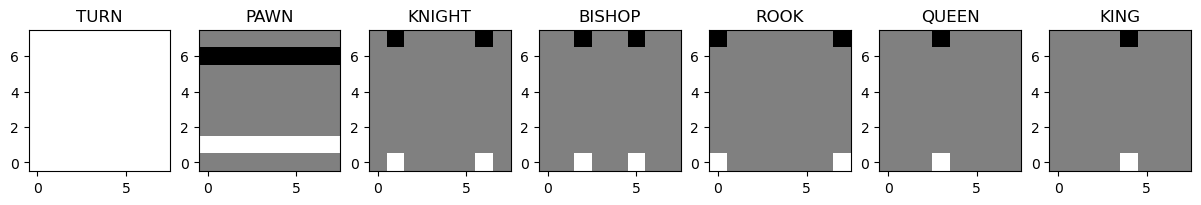

In [10]:
board = chess.Board()
tensor = board_to_tensor(board)
plot_pos_tensor(tensor)

In [11]:
moves_start = torch.zeros(64*64)
valid_actions_start = [move_to_action(move) for move in board.legal_moves]
moves_start[valid_actions_start] = 1
moves_start.sum()

tensor(20.)

In [12]:
def plot_move_set(moves: torch.Tensor):
    moves_view = torch.zeros(64, 64)
    for start_row in range(8):
        for start_col in range(8):
            for end_row in range(8):
                for end_col in range(8):
                    action_num = (start_row+start_col*8)*64+(end_row+end_col*8)
                    moves_view[start_col*8+end_col][start_row*8+end_row] = moves[action_num]
    plt.imshow(moves_view, origin="lower", vmin=0, vmax=1)
    plt.show()

In [ ]:
plot_move_set(moves_start)

In [29]:
def plot_board_moves(board: chess.Board, probs: torch.Tensor, k=20):
    arrows = []
    probs, actions = torch.topk(probs, k)
    for prob, action in zip(probs, actions):
        arrow_color = f"#009900{int(prob*128):02x}"
        move = action_to_move(action.item(), board)
        print(move, prob)
        arrows.append(chess.svg.Arrow(move.from_square, move.to_square, color=arrow_color))
    return chess.svg.board(board, arrows=arrows)

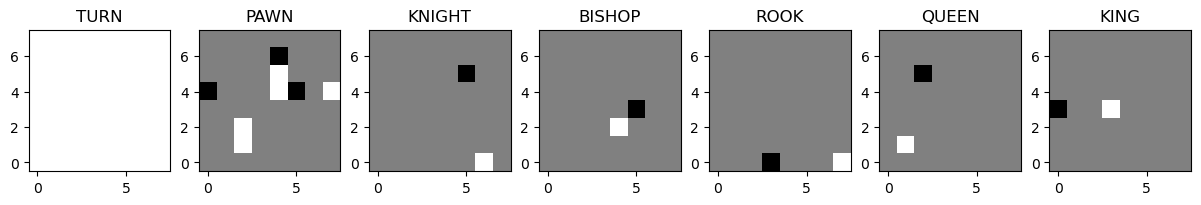

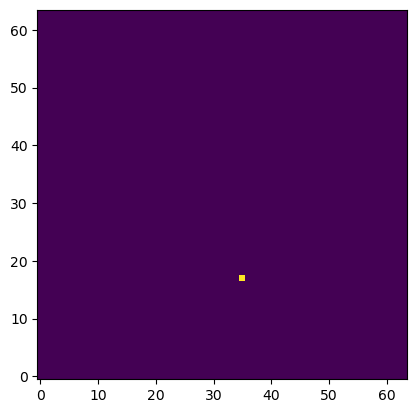

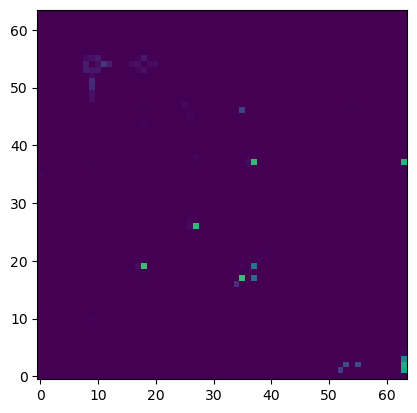

c3c4 tensor(0.6879)
e3d2 tensor(0.6831)
e5f6 tensor(0.6757)
d4d3 tensor(0.6654)
h5h6 tensor(0.6511)
h1h3 tensor(0.6164)
h1h2 tensor(0.5898)
h1h4 tensor(0.4512)
e3f4 tensor(0.3785)
e3f2 tensor(0.3347)
g1h3 tensor(0.2313)
g1f3 tensor(0.2279)
e6d7 tensor(0.1925)
g1e2 tensor(0.1844)
b7d7 tensor(0.1606)
e3c1 tensor(0.1327)
b7b4 tensor(0.1182)
b7b3 tensor(0.1142)
b7e7 tensor(0.0831)
b7a7 tensor(0.0757)
b7c8 tensor(0.0728)
b7a6 tensor(0.0706)
c7c8 tensor(0.0649)
b7b6 tensor(0.0597)
b7c6 tensor(0.0547)
b7b8 tensor(0.0476)
c7b7 tensor(0.0440)
b7b2 tensor(0.0439)
c7c6 tensor(0.0439)
b7b1 tensor(0.0422)
b7c7 tensor(0.0386)
c7e7 tensor(0.0331)
c7d7 tensor(0.0319)
c3b4 tensor(0.0316)
e5e6 tensor(0.0312)
b7b5 tensor(0.0311)
d6b8 tensor(0.0306)
b7a8 tensor(0.0301)
c7a7 tensor(0.0299)
d4c3 tensor(0.0251)
c7b8 tensor(0.0193)
e3d4 tensor(0.0136)
a5a4 tensor(0.0136)
c7b6 tensor(0.0130)
d5d7 tensor(0.0127)
d6c6 tensor(0.0126)
h1h5 tensor(0.0125)
d4c4 tensor(0.0125)
e3g5 tensor(0.0124)
e3h6 tensor(0.0113)


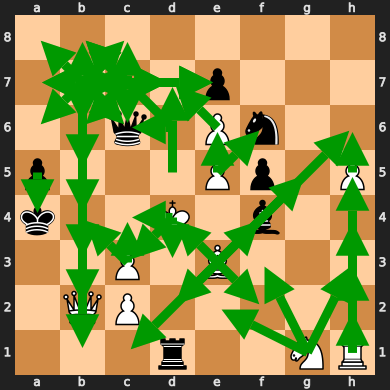

In [36]:
idx = 142
plot_pos_tensor(positions[idx])
plot_move_set(valid_moves[idx])
move_probs = model(positions[[idx]])[0].detach()
plot_move_set(move_probs)
plot_board_moves(tensor_to_board(positions[idx]), move_probs, k=50)

In [ ]:
for i in range(0,200,10):
    for l in range(7):
        print((positions[i][l] != 0).sum(), end=" ")
    print()

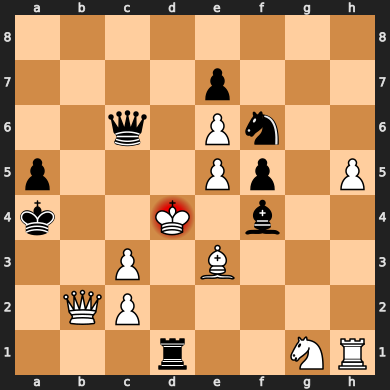

In [35]:
tensor_to_board(positions[142])